In [24]:
import os
import re
import pathlib
import time
import itertools
import glob
import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
from IPython import display
from sklearn.model_selection import train_test_split

from generator import *
from discriminator import *
from loss import *
from utils import *

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading dataset

In [9]:
city = 'nyc'
date = 'dec-21'
zoom = 15
shadow_path = 'e://Dropbox/vgc//shadow-slippy-vis//www//assets//%s-%s//'%(city,date)
height_path = 'data/%s-heights/'%(city)
checkpoint_path = './training_checkpoints/%s-%s'%(city,date)

# Training size
BUFFER_SIZE = 400


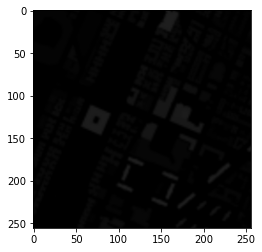

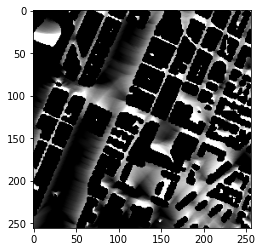

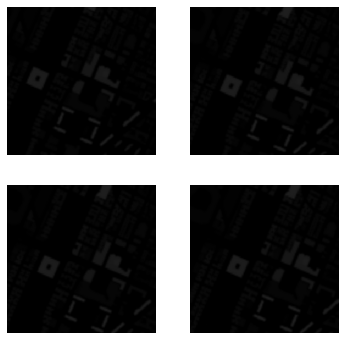

In [14]:
inp, real = load(height_path, shadow_path, zoom, 9655, 12306)

# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(real / 255.0)
plt.show()

plt.figure(figsize=(6, 6))
for i in range(4):
    rj_inp, rj_re = random_jitter(inp, real)
    plt.subplot(2, 2, i + 1)
    plt.imshow(rj_inp / 255.0)
    plt.axis('off')
plt.show()

## Build generator

(1, 128, 128, 3)
(1, 256, 256, 3)


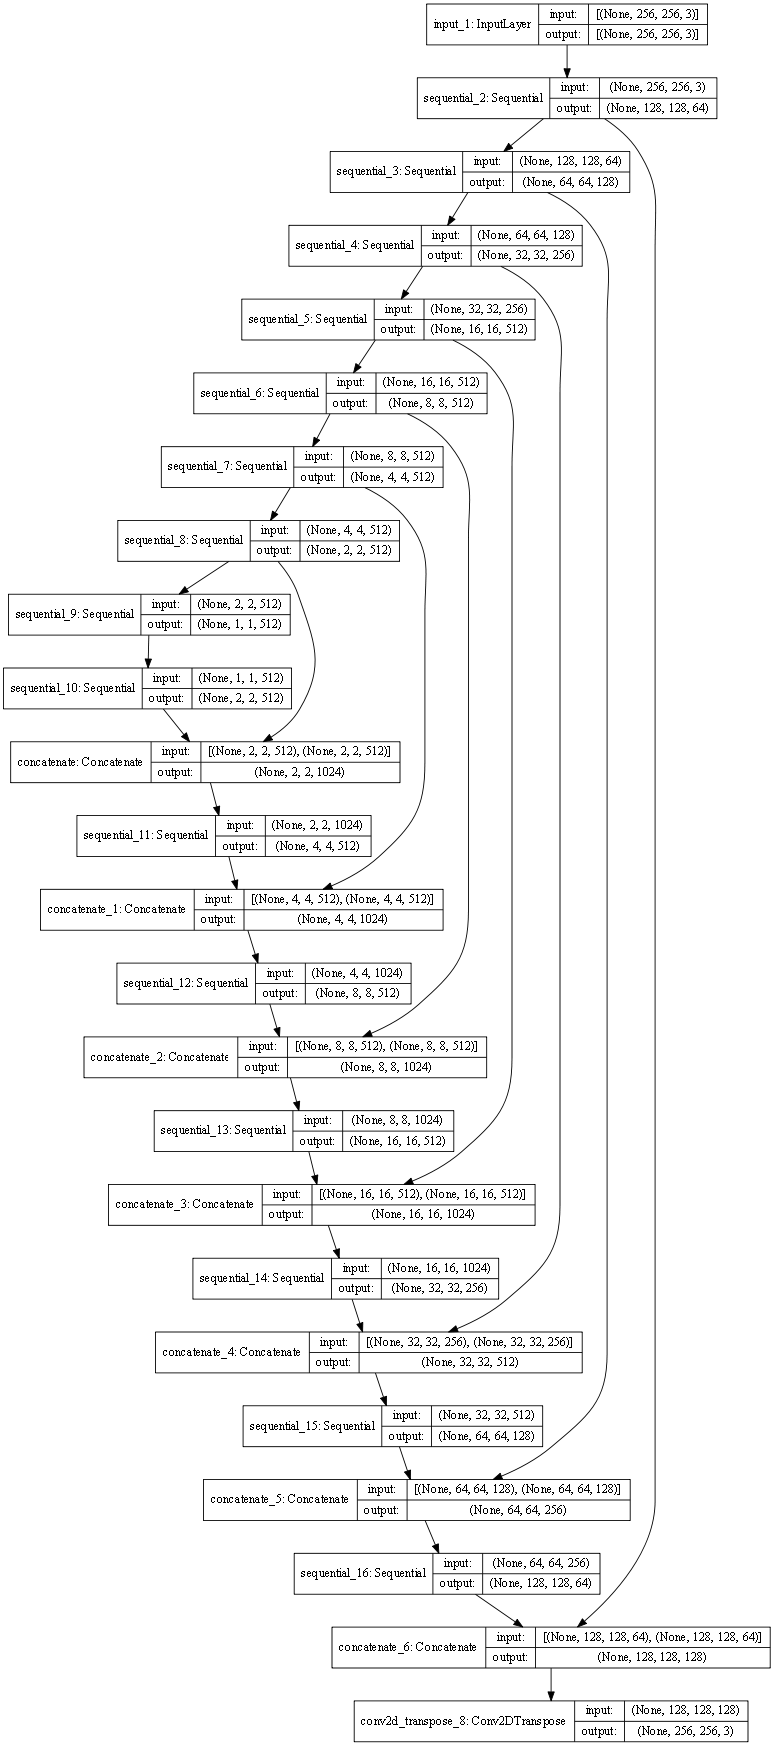

In [15]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


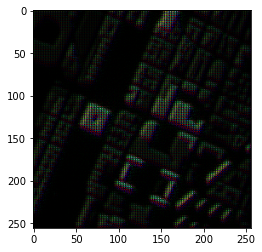

In [16]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

## Build discriminator

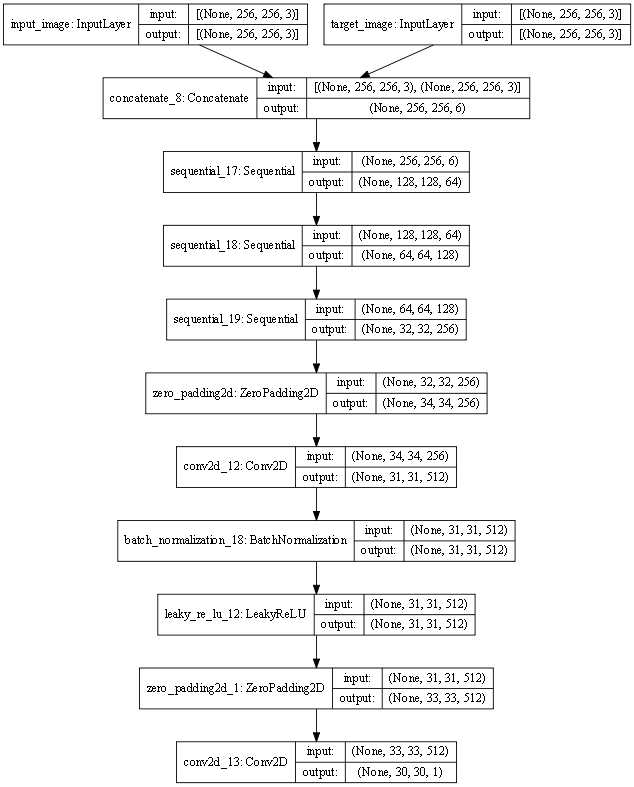

In [18]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

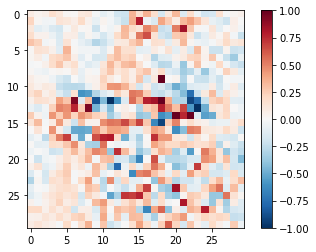

In [19]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-1, vmax=1, cmap='RdBu_r')
plt.colorbar()

## Optimizers and a checkpoint-saver

In [20]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [22]:
checkpoint_prefix = os.path.join(checkpoint_path, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Generate images

In [45]:
train_dataset, test_dataset = get_train_test(shadow_path, city, date, zoom)

NameError: name 'get_train_test' is not defined

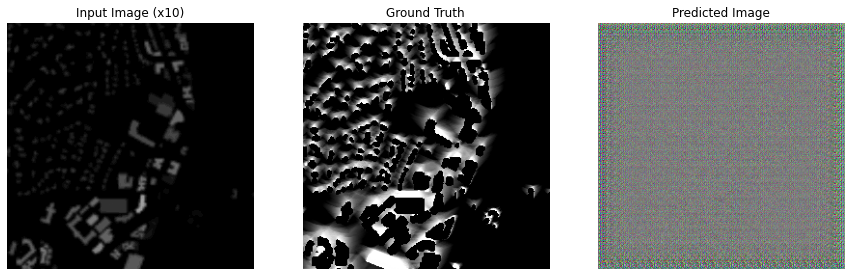

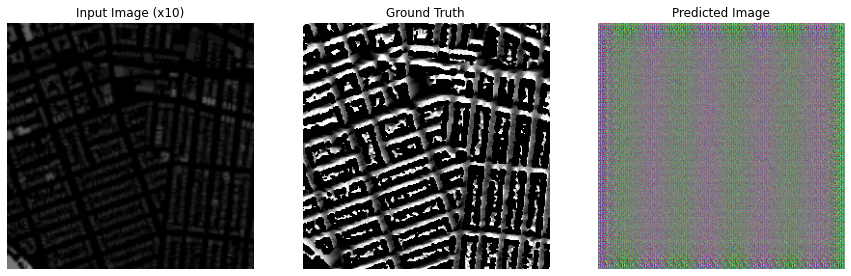

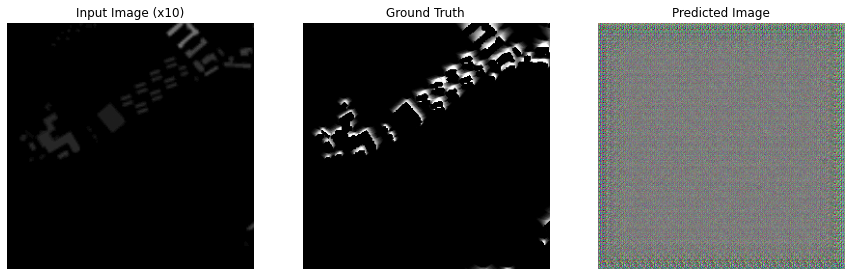

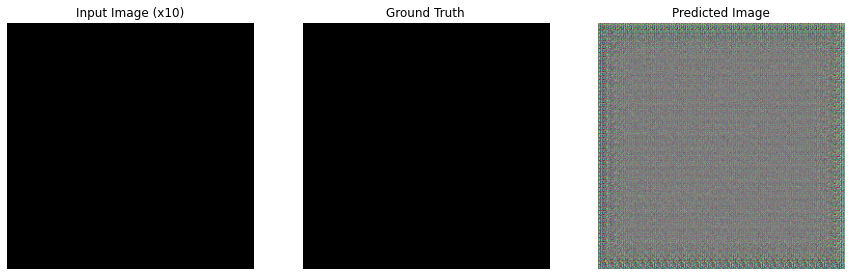

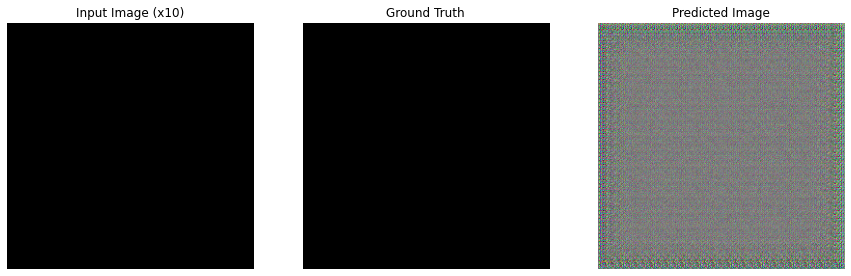

In [38]:
for example_input, example_target in test_dataset.take(5):
    generate_images(generator, example_input, example_target)

## Training

In [39]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [40]:
@tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
        

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
        tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [41]:
def fit(train_ds, test_ds, steps):
    example_input, example_target = next(iter(test_ds.take(1)))
    start = time.time()

    for step, (input_image, target) in train_ds.repeat().take(steps).enumerate(): 
        if (step) % 1000 == 0:
            display.clear_output(wait=True)

            if step != 0:
                print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

            start = time.time()

            generate_images(generator, example_input, example_target)
            print(f"Step: {step//1000}k")

        train_step(input_image, target, step)

        # Training step
        if (step+1) % 10 == 0:
            print('.', end='', flush=True)


        # Save (checkpoint) the model every 5k steps
        if (step + 1) % 5000 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [26]:
%load_ext tensorboard
%tensorboard --logdir {log_dir} --port 8088

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


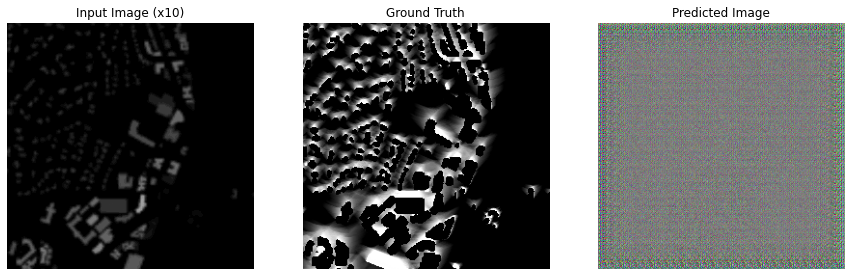

Step: 0k
..............

KeyboardInterrupt: 

In [42]:
fit(train_dataset, test_dataset, steps=40000)